<a href="https://colab.research.google.com/github/dai02012000/LinearPredictQualityWine/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision
import numpy as np

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False # cho kết quả mỗi lần chạy giống nhau 
torch.manual_seed(random_seed)

In [3]:
# load data into numpy

from mlxtend.data import loadlocal_mnist

train_data, train_target = loadlocal_mnist(
    images_path='/content/drive/MyDrive/Colab Notebooks/MNIST/raw/train-images-idx3-ubyte',
    labels_path='/content/drive/MyDrive/Colab Notebooks/MNIST/raw/train-labels-idx1-ubyte'
)
test_data, test_target = loadlocal_mnist(
    images_path='/content/drive/MyDrive/Colab Notebooks/MNIST/raw/t10k-images-idx3-ubyte',
    labels_path='/content/drive/MyDrive/Colab Notebooks/MNIST/raw/t10k-labels-idx1-ubyte'
)


In [4]:
train_data.shape, train_target.shape, test_data.shape, test_target.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [5]:
# chuyển về torch và đúng shape
train_data = torch.from_numpy(train_data).to(torch.float32)
train_target = torch.from_numpy(train_target).type(torch.LongTensor)
test_data = torch.from_numpy(test_data).to(torch.float32)
test_target = torch.from_numpy(test_target).type(torch.LongTensor)

train_data = train_data.view(-1 ,1, 28, 28)
test_data = test_data.view( -1,1, 28, 28)

train_data.type(), test_data.shape

('torch.FloatTensor', torch.Size([10000, 1, 28, 28]))

In [6]:
from google.colab.patches import cv2_imshow 
import numpy as np

cv2_imshow(np.array(train_data[1].permute(1, 2, 0)))

In [7]:
#normalized
train_data /= 255.
test_data /= 255.


train_data = (train_data - 0.1307)/0.3081
test_data = (test_data - 0.1307)/0.3081

In [8]:
batch_size = 64

iter_train = int(train_data.shape[0]/batch_size)
train_loader = []
for i in range(1, iter_train+2):
  data = train_data[(i-1)*batch_size : i*batch_size]
  target =  train_target[(i-1)*batch_size : i*batch_size]
  ex = [data, target]
  train_loader.append(ex)

iter_test = int(test_data.shape[0]/batch_size)
test_loader = []
for i in range(1, iter_test):
  data = test_data[(i-1)*batch_size : i*batch_size]
  target =  test_target[(i-1)*batch_size : i*batch_size]
  ex = [data, target]
  test_loader.append(ex)



In [9]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.type(), example_targets.type()

('torch.FloatTensor', 'torch.LongTensor')

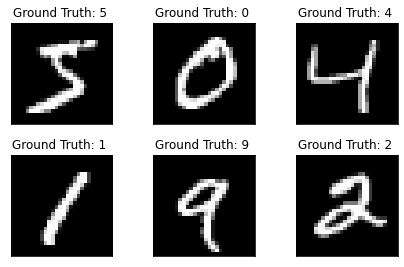

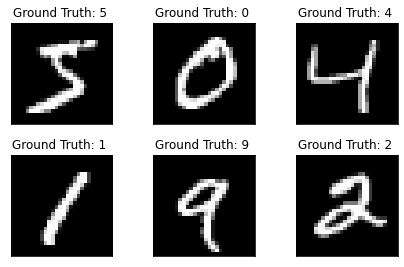

In [84]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title('Ground Truth: {} '.format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [111]:
m = nn.Dropout(p = 0.4)
input = torch.ones(2,5)
m(input)

tensor([[1.6667, 0.0000, 0.0000, 1.6667, 1.6667],
        [0.0000, 0.0000, 0.0000, 1.6667, 0.0000]])

In [11]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(32*14*14, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2) # giảm chiều dài và rộng đi 1 nửa
    x = self.dropout1(x)
    # Flatten(làm phẳng) về dạng vector 
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim = 1)
    return output


In [113]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader) for i in range(n_epochs + 1)]

In [17]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx,  (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print("Train Epoch: {} [{}/{}] \tLoss: {:.6f} ".format(
          epoch, batch_idx , len(train_loader), loss.item()
      ))
      # train_losses.append(loss.item()) # luu lại các loss để  visual
      # train_counter.append((batch_idx*64)+((epoch-1)*len(train_loader.dataset)))

      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model.pth')
      torch.save(optimizer.state_dict, '/content/drive/MyDrive/Colab Notebooks/optimizer.pth')

In [18]:
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True) # lấy chỉ sổ
      correct += pred.eq(target.view_as(pred)).sum().item()
  # test_loss /= len(test_loader.dataset)
  # test_losses.append(test_loss)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader)*batch_size,
        100. * correct / (len(test_loader)*batch_size)))

In [15]:
use_cuda =torch.cuda.is_available()
device = torch.device('cuda'if use_cuda else 'cpu')
device

device(type='cuda')

In [19]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)

for epoch in range(1, n_epochs):
  train(net, device, train_loader, optimizer, epoch)
  test(net, device, test_loader)

Train Epoch: 1 [0/938] 	Loss: 2.308214 
Train Epoch: 1 [10/938] 	Loss: 1.357754 
Train Epoch: 1 [20/938] 	Loss: 0.801644 
Train Epoch: 1 [30/938] 	Loss: 0.614631 
Train Epoch: 1 [40/938] 	Loss: 0.386379 
Train Epoch: 1 [50/938] 	Loss: 0.625054 
Train Epoch: 1 [60/938] 	Loss: 0.474294 
Train Epoch: 1 [70/938] 	Loss: 0.333200 
Train Epoch: 1 [80/938] 	Loss: 0.607447 
Train Epoch: 1 [90/938] 	Loss: 0.350618 
Train Epoch: 1 [100/938] 	Loss: 0.368562 
Train Epoch: 1 [110/938] 	Loss: 0.273252 
Train Epoch: 1 [120/938] 	Loss: 0.338365 
Train Epoch: 1 [130/938] 	Loss: 0.113435 
Train Epoch: 1 [140/938] 	Loss: 0.256971 
Train Epoch: 1 [150/938] 	Loss: 0.503287 
Train Epoch: 1 [160/938] 	Loss: 0.563718 
Train Epoch: 1 [170/938] 	Loss: 0.143343 
Train Epoch: 1 [180/938] 	Loss: 0.446549 
Train Epoch: 1 [190/938] 	Loss: 0.319343 
Train Epoch: 1 [200/938] 	Loss: 0.237151 
Train Epoch: 1 [210/938] 	Loss: 0.223107 
Train Epoch: 1 [220/938] 	Loss: 0.250897 
Train Epoch: 1 [230/938] 	Loss: 0.428674 
Tra

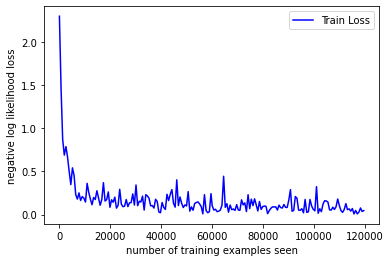

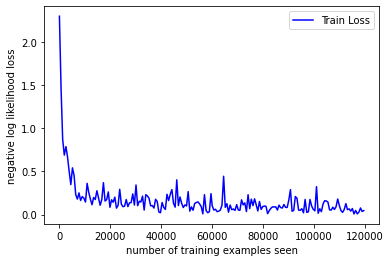

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [22]:
with torch.no_grad():
  output = net(example_data.to(device))



In [ ]:
output.data.max(1, keepdim=True)[1][1].item()

2

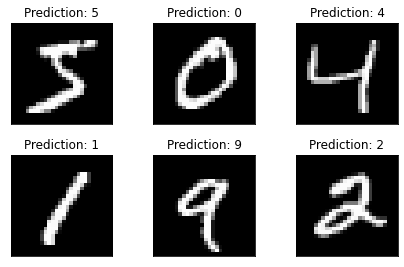

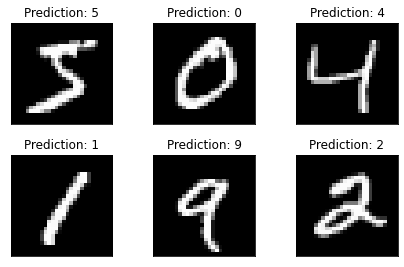

In [23]:
import matplotlib.pyplot as plt


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.to(device).data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig